In [1]:
import numpy as np
import FactorBP as FB
import scipy.io as sio
import matlab.engine
import time
eng = matlab.engine.start_matlab()

In [4]:
def ComputeAccurancy(Decode, gTruth, NofInliers):
    Ccnt = 0
    for i in range(NofInliers):
        if(Decode[i] == gTruth[i]):
            Ccnt += 1
    return 1.0 * Ccnt / NofInliers

def LoadHouse():
    res = np.zeros([111, 30, 2])
    for i in range(1,112):
        res[i-1] = np.loadtxt('data/cmum/house/label/house%d' %i)
    return res
HouseData = LoadHouse()
NofAlgorithms = 8
AlgorithmNames=['Ours', 'Ours-BCA', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM']
start = 0
end = 111
MeanAcc = np.zeros([10,NofAlgorithms])
MeanRtime = np.zeros([10, NofAlgorithms])
MeanObj = np.zeros([10, NofAlgorithms])
AllAcc = {}
AllRtim = {}
AllObj = {}
Type = 'topo'

for baseline in xrange(10,101,10):
    print(' Start baseline: %d' % (baseline))
    AllAcc[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    AllRtim[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    # AllObj[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    Obj = np.zeros([NofAlgorithms, end - baseline])

    for ImageI in range(start, end - baseline):
        PT1 = np.copy(HouseData[ImageI])
        PT2 = np.copy(HouseData[ImageI+baseline])
        NofNodes = 30
        gTruth = np.random.permutation(NofNodes)
        PT1 = PT1[gTruth, :]
        PF1 = np.zeros([NofNodes,1])
        PF2 = np.zeros([NofNodes,2])
        MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
        MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])
        
        [G, FName] = FB.ConstructMatchingModel(MG1, MG2, Type, True, False)
        # G2 = FB.ConstructMatchingModel(MG1, MG2, Type, False, True)
        [Gvis, FName] = FB.ConstructMatchingModel(MG1, MG2, Type, True, False)
        G.SetVerbose(False)

        # Our results 1
        res1 = FB.BaBSolver(G, 30, 10, 0.005, False)
        AllAcc[(baseline-10)/10][0][ImageI] = ComputeAccurancy(res1.Decode, gTruth, NofNodes)
        AllRtim[(baseline-10)/10][0][ImageI] = res1.Time
        Obj[0][ImageI] = res1.Value
        #end Our results 1
        
        # BCA
        resBag = eng.runBcagm(FName, nargout=3)
        AllAcc[(baseline-10)/10][2][ImageI] = ComputeAccurancy(resBag[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][2][ImageI] = resBag[0]
        cDecode = FB.intArray(NofNodes)
        for i in range(NofNodes):
            cDecode[i] = int(resBag[1][0][i])
        Obj[2][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA
        
        # BCA-MP
        resBagMP = eng.runBcagmQuad1(FName, 1,nargout=3)
        AllAcc[(baseline-10)/10][3][ImageI] = ComputeAccurancy(resBagMP[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][3][ImageI] = resBagMP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagMP[1][0][i])
        Obj[3][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA-MP
        
        # BCA-IPFP
        resBagIPFP = eng.runBcagmQuad1(FName, 2,nargout=3)
        AllAcc[(baseline-10)/10][4][ImageI] = ComputeAccurancy(resBagIPFP[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][4][ImageI] = resBagIPFP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagIPFP[1][0][i])
        Obj[4][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA-IPFP
        
        # HGM
        resHGM = eng.runHGM(FName, nargout=3)
        AllAcc[(baseline-10)/10][5][ImageI] = ComputeAccurancy(resHGM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][5][ImageI] = resHGM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resHGM[1][0][i])
        Obj[5][ImageI] = Gvis.ComputeObj(cDecode)
        #end HGM
        
        # RRWHM
        resRRWHM = eng.runRRWHM(FName, nargout=3)
        #resRRWHM = eng.runBcagm(nargout=3)
        AllAcc[(baseline-10)/10][6][ImageI] = ComputeAccurancy(resRRWHM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][6][ImageI] = resRRWHM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resRRWHM[1][0][i])
        Obj[6][ImageI] = Gvis.ComputeObj(cDecode)
        #end RRWHM
        
        # TensorMatching
        resTM = eng.runTensorMatching(FName, nargout=3)
        AllAcc[(baseline-10)/10][7][ImageI] = ComputeAccurancy(resTM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][7][ImageI] = resTM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resTM[1][0][i])
        Obj[7][ImageI] = Gvis.ComputeObj(cDecode)
        #end TensorMatching
        
        # Our-BCA Results
        start_time = time.time()
        ResForBca = sio.loadmat(FName)
        X0 = np.zeros(NofNodes)
        X0Vec = res1.Decode
        for i in xrange(NofNodes):
            X0[i] = X0Vec[i]
        ResForBca['X0'] = X0
        sio.savemat(FName, ResForBca)
        resOursBCA = eng.runBcagm(FName, nargout=3)
        time_dur = time.time() - start_time

        cDecode = FB.intArray(NofNodes)
        #print(resOursBCA[1][0])
        for i in range(NofNodes):
            cDecode[i] = int(resOursBCA[1][0][i])
        if res1.Value < Gvis.ComputeObj(cDecode):
            AllAcc[(baseline-10)/10][1][ImageI] = ComputeAccurancy(resOursBCA[1][0], gTruth, NofNodes)
            Obj[1][ImageI] = Gvis.ComputeObj(cDecode)
        else:
            AllAcc[(baseline-10)/10][1][ImageI] = ComputeAccurancy(res1.Decode, gTruth, NofNodes)
            Obj[1][ImageI] = res1.Value
        AllRtim[(baseline-10)/10][1][ImageI] = time_dur + res1.Time
        #end Our-BCA Results
        
        MaxObj = np.max(Obj[:,ImageI])
        Obj[:,ImageI] /= MaxObj
        AllObj[(baseline-10)/10] = Obj
        #for ai in xrange(NofAlgorithms):
        #    print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
        #                                                     AllAcc[(baseline-10)/10][ai][ImageI],
        #                                                    AllRtim[(baseline-10)/10][ai][ImageI],
        #                                                   AllObj[(baseline-10)/10][ai][ImageI]))
        #print(' Finished Frame: %d ----------------------' % (ImageI) )
        #end inner loop
    for ai in xrange(NofAlgorithms):
        MeanAcc[(baseline-10)/10][ai] = np.mean(AllAcc[(baseline-10)/10][ai])
        MeanRtime[(baseline-10)/10][ai] = np.mean(AllRtim[(baseline-10)/10][ai])
        # MeanObj[(baseline-10)/10][ai] = np.mean(Obj[ai])
        MeanObj[(baseline-10)/10][ai] = np.mean(AllObj[(baseline-10)/10][ai])
        print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                        MeanAcc[(baseline-10)/10][ai],
                                                        MeanRtime[(baseline-10)/10][ai],
                                                        MeanObj[(baseline-10)/10][ai]))
    print('××××××××××××××××××××')
    #end outer loop

 Start baseline: 10


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 1.000000 Running Time 0.003246 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.033400 Obj 1.000000
BCA Accuracy 1.000000 Running Time 0.021334 Obj 1.000000
BCA-MP Accuracy 1.000000 Running Time 0.113397 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.085855 Obj 1.000000
HGM Accuracy 0.962706 Running Time 0.011424 Obj 0.953366
RRWHM Accuracy 1.000000 Running Time 0.044324 Obj 1.000000
TM Accuracy 0.997360 Running Time 0.076202 Obj 0.998736
××××××××××××××××××××
 Start baseline: 20


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 1.000000 Running Time 0.004242 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.039028 Obj 1.000000
BCA Accuracy 1.000000 Running Time 0.023422 Obj 1.000000
BCA-MP Accuracy 1.000000 Running Time 0.127067 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.092178 Obj 1.000000
HGM Accuracy 0.913187 Running Time 0.011335 Obj 0.893184
RRWHM Accuracy 1.000000 Running Time 0.049138 Obj 1.000000
TM Accuracy 0.994139 Running Time 0.081275 Obj 0.995319
××××××××××××××××××××
 Start baseline: 30


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 1.000000 Running Time 0.006832 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.040305 Obj 1.000000
BCA Accuracy 1.000000 Running Time 0.022930 Obj 1.000000
BCA-MP Accuracy 1.000000 Running Time 0.128108 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.094498 Obj 1.000000
HGM Accuracy 0.846502 Running Time 0.011641 Obj 0.810635
RRWHM Accuracy 1.000000 Running Time 0.055854 Obj 1.000000
TM Accuracy 0.974074 Running Time 0.082336 Obj 0.978004
××××××××××××××××××××
 Start baseline: 40


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 1.000000 Running Time 0.014283 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.046902 Obj 1.000000
BCA Accuracy 0.998122 Running Time 0.023938 Obj 0.998243
BCA-MP Accuracy 1.000000 Running Time 0.128051 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.094515 Obj 1.000000
HGM Accuracy 0.752113 Running Time 0.011486 Obj 0.711778
RRWHM Accuracy 1.000000 Running Time 0.063646 Obj 1.000000
TM Accuracy 0.913615 Running Time 0.081086 Obj 0.929835
××××××××××××××××××××
 Start baseline: 50


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 1.000000 Running Time 0.041515 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.073355 Obj 1.000000
BCA Accuracy 0.998907 Running Time 0.023355 Obj 0.999090
BCA-MP Accuracy 1.000000 Running Time 0.126226 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.094461 Obj 1.000000
HGM Accuracy 0.653005 Running Time 0.010910 Obj 0.617151
RRWHM Accuracy 1.000000 Running Time 0.067807 Obj 1.000000
TM Accuracy 0.855738 Running Time 0.081508 Obj 0.877598
××××××××××××××××××××
 Start baseline: 60


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 1.000000 Running Time 0.100715 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.132781 Obj 1.000000
BCA Accuracy 0.986928 Running Time 0.024071 Obj 0.991332
BCA-MP Accuracy 0.998693 Running Time 0.141698 Obj 0.999634
BCA-IPFP Accuracy 1.000000 Running Time 0.093845 Obj 1.000000
HGM Accuracy 0.603922 Running Time 0.010981 Obj 0.595799
RRWHM Accuracy 1.000000 Running Time 0.080944 Obj 1.000000
TM Accuracy 0.758824 Running Time 0.079313 Obj 0.813897
××××××××××××××××××××
 Start baseline: 70


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 0.998374 Running Time 0.223041 Obj 1.000000
Ours-BCA Accuracy 0.998374 Running Time 0.257648 Obj 1.000000
BCA Accuracy 0.977236 Running Time 0.024745 Obj 0.984897
BCA-MP Accuracy 0.996748 Running Time 0.167637 Obj 0.997131
BCA-IPFP Accuracy 0.998374 Running Time 0.098478 Obj 1.000000
HGM Accuracy 0.521951 Running Time 0.011403 Obj 0.547603
RRWHM Accuracy 1.000000 Running Time 0.088765 Obj 0.999716
TM Accuracy 0.655285 Running Time 0.080365 Obj 0.742037
××××××××××××××××××××
 Start baseline: 80


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 0.993548 Running Time 0.335980 Obj 0.998551
Ours-BCA Accuracy 0.997849 Running Time 0.369341 Obj 1.000000
BCA Accuracy 0.973118 Running Time 0.023189 Obj 0.983589
BCA-MP Accuracy 0.972043 Running Time 0.182633 Obj 0.982647
BCA-IPFP Accuracy 0.997849 Running Time 0.100481 Obj 1.000000
HGM Accuracy 0.462366 Running Time 0.010961 Obj 0.537475
RRWHM Accuracy 1.000000 Running Time 0.103759 Obj 0.999573
TM Accuracy 0.541935 Running Time 0.083627 Obj 0.676240
××××××××××××××××××××
 Start baseline: 90


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 0.987302 Running Time 0.440418 Obj 0.998166
Ours-BCA Accuracy 0.992063 Running Time 0.474296 Obj 1.000000
BCA Accuracy 0.930159 Running Time 0.024715 Obj 0.967747
BCA-MP Accuracy 0.904762 Running Time 0.224829 Obj 0.955754
BCA-IPFP Accuracy 0.992063 Running Time 0.109893 Obj 1.000000
HGM Accuracy 0.414286 Running Time 0.011287 Obj 0.516428
RRWHM Accuracy 0.995238 Running Time 0.117368 Obj 0.999448
TM Accuracy 0.436508 Running Time 0.083290 Obj 0.608393
××××××××××××××××××××
 Start baseline: 100


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 0.954545 Running Time 0.463304 Obj 0.979498
Ours-BCA Accuracy 0.966667 Running Time 0.495664 Obj 0.992289
BCA Accuracy 0.881818 Running Time 0.027862 Obj 0.958748
BCA-MP Accuracy 0.848485 Running Time 0.267982 Obj 0.953980
BCA-IPFP Accuracy 0.987879 Running Time 0.122869 Obj 0.995023
HGM Accuracy 0.284848 Running Time 0.014927 Obj 0.498835
RRWHM Accuracy 0.963636 Running Time 0.163624 Obj 0.991066
TM Accuracy 0.296970 Running Time 0.089826 Obj 0.558411
××××××××××××××××××××


array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  0.99837398,  0.99354839,  0.98730159,  0.95454545])

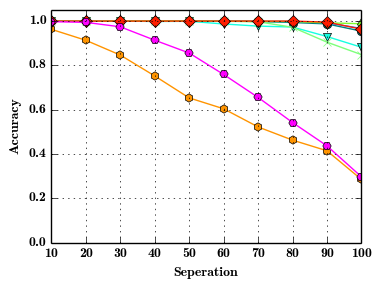

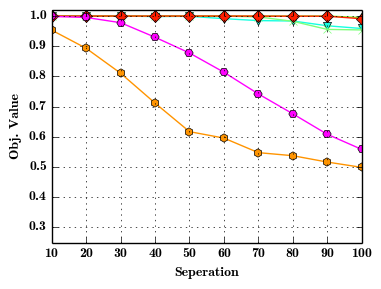

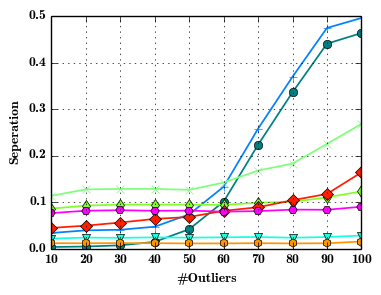

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import pylab
%matplotlib inline

Colors = [[ 0.        ,  0.5       , 0.5        ,  1.        ],   #1
          # [ 1.        ,  0.00196078,  1.        ,  1.        ],   #2
          [ 0.        ,  0.50392157,  1.        ,  1.        ],   #3
          [ 0.08538899,  1.        ,  0.88235294,  1.        ],   #4
          [ 0.49019608,  1.        ,  0.47754586,  1.        ],   #5
          [ 0.5       ,  1.        ,  0.17273877,  1.        ],   #6
          [ 1.        ,  0.58169935,  0.        ,  1.        ],   #7
          [ 1.        ,  0.11692084,  0.        ,  1.        ],   #8
          [ 1.        ,  0.        ,  1.        ,  1.        ]];  #9
Seq = [0, 1, 2, 3, 4, 5, 6, 7]
AlgorithmNames=['Ours', 'Ours-BCA', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM']
Markers = ['o', '+', 'v', 'x', 'd', 'h', 'D', 'H']

figData = pylab.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
ax = pylab.gca()

matplotlib.rc('font',family='Times New Roman')


#plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

for ai in xrange(NofAlgorithms):
    pylab.plot(range(10,101,10), MeanAcc[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
pylab.ylim([0,1.05])
pylab.grid(True)

pylab.ylabel('Accuracy')
pylab.xlabel('Seperation')


figLegend = pylab.figure(figsize = (11.7,0.4))
pylab.figlegend(*ax.get_legend_handles_labels(), loc = 'upper center',  ncol=9, shadow=True, fancybox=True)
figData.savefig('results/'+Type+'/TripletsOnly/House_Acc.pdf')
#figLegend.savefig("legend.pdf")
figLegend.show()

#plt.legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5,-0.25), ncol=9)
#plt.savefig('House_ACC.pdf')    # <-- loses transparency

StoreForPlot ={}
StoreForPlot['Accuracy'] = MeanAcc
StoreForPlot['Time'] = MeanRtime
StoreForPlot['Obj'] = MeanObj

sio.savemat('results/'+Type+'/TripletsOnly/PlotData.mat', StoreForPlot)

plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    if(AlgorithmNames[Seq[ai]] == 'Ours')|(AlgorithmNames[Seq[ai]] == 'Ours-BCA'):
        continue
    plt.plot(range(10,101,10), MeanObj[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
plt.ylim([0.25,1.02])
plt.ylabel('Obj. Value')
plt.xlabel('Seperation')
plt.grid(True)
plt.savefig('results/'+Type+'/TripletsOnly/House_Obj.pdf')    # <-- loses transparency


plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(10,101,10), MeanRtime[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]], linewidth=1.25)

plt.ylabel('Seperation')
plt.xlabel('#Outliers')

plt.grid(True)
plt.savefig('results/'+Type+'/TripletsOnly/Car_Time.pdf')    # <-- loses transparency

MeanAcc[:,0]

In [ ]:
PT1 = np.copy(HouseData[ImageI])
PT2 = np.copy(HouseData[ImageI+baseline])
NofNodes = 30
gTruth = np.random.permutation(NofNodes)
PT1 = PT1[gTruth, :]
PF1 = np.zeros([NofNodes,1])
PF2 = np.zeros([NofNodes,2])
MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])
G = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True, False)
res1 = FB.BaBSolver(G, 30, 10, 0.005, True)